In [34]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

import statsmodels.api as sm

from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.static import players

season = None
game_id = None

In [2]:
master_df = pd.DataFrame(columns=['diff_per_100'])
master_df

Empty DataFrame
Columns: [diff_per_100]
Index: []

# Building X/Y data

In [3]:
def get_season_stint_master(season):
    path = f'/home/cody/workspace/nba_pbp/data/{season}/{season}-stint_matrix.csv'
    master_df = pd.read_csv(path)
    if 'Unnamed: 0' in master_df.columns:
        master_df = master_df.drop(['Unnamed: 0'],axis=1)
        
    return master_df

In [4]:
def get_all_season_stints():
    files = glob.glob(f'/home/cody/workspace/nba_pbp/data/*/*-stint_matrix.csv')
    
    master_df = pd.DataFrame()
    for file in files:
        temp = pd.read_csv(file)
        if master_df.empty:
            master_df = temp
        else:
            master_df = master_df.append(temp)

    if 'Unnamed: 0' in master_df.columns:
        master_df = master_df.drop(['Unnamed: 0'],axis=1)
    
    master_df = master_df.fillna(0)
    
    return master_df.reset_index(drop=True)

master_df = get_all_season_stints()

In [5]:
y_hat = master_df.pop('diff_per_100')
print(master_df.shape)
master_df.head()

(108063, 864)


201980  2544  203076  202340  200765  203484  1627936  1629668  1629719  \
0     1.0   1.0     1.0     1.0     1.0     0.0      0.0      0.0      0.0   
1     1.0   1.0     1.0     1.0     1.0     0.0      0.0      0.0      0.0   
2     1.0   1.0     1.0     1.0     0.0     1.0      0.0      0.0      0.0   
3     1.0   1.0     1.0     1.0     0.0     1.0      0.0      0.0      0.0   
4     0.0   1.0     1.0     0.0     0.0     1.0      1.0      1.0      0.0   

   201580  ...  1630651  1630603  1628591  204028  1629083  1630639  1629788  \
0     0.0  ...      0.0      0.0      0.0     0.0      0.0      0.0      0.0   
1     0.0  ...      0.0      0.0      0.0     0.0      0.0      0.0      0.0   
2     0.0  ...      0.0      0.0      0.0     0.0      0.0      0.0      0.0   
3     0.0  ...      0.0      0.0      0.0     0.0      0.0      0.0      0.0   
4     0.0  ...      0.0      0.0      0.0     0.0      0.0      0.0      0.0   

   1630642  1630835  1629309  
0      0.0      0.0      0.0  
1      0.0      0.0      0.0  
2      0.0      0.0      0.0  
3      0.0      0.0      0.0  
4      0.0      0.0      0.0  

[5 rows x 864 columns]

In [6]:
def get_season_stats(season):
    player_stats = leaguedashplayerstats.LeagueDashPlayerStats(season=season).get_data_frames()[0]
    return player_stats

In [7]:
seasons = ['2019-20','2020-21','2021-22']

def get_multi_season_stats(seasons):
    season_stats = pd.DataFrame()
    for season in seasons:
        temp = get_season_stats(season)
        if season_stats.empty:
            season_stats = temp
        else:
            season_stats = season_stats.append(temp)
    
    season_stats = season_stats[['PLAYER_ID','PLAYER_NAME','MIN']]
    
    # We don't include any players that don't appear every season
    season_counts = season_stats['PLAYER_ID'].value_counts()
    season_stats = season_stats[season_stats['PLAYER_ID'].map(season_counts) == len(seasons)]
    
    # Group by players and average mins played
    season_stats = season_stats.groupby(['PLAYER_ID','PLAYER_NAME']).mean().reset_index()
    
    return season_stats

player_stats = get_multi_season_stats(seasons)
player_stats.head()

PLAYER_ID      PLAYER_NAME          MIN
0       2544     LeBron James  1954.928889
1       2546  Carmelo Anthony  1764.912778
2       2617    Udonis Haslem    35.211667
3       2730    Dwight Howard  1107.590556
4       2738   Andre Iguodala   758.473333

In [8]:
# Split players stats into less than and greater than X mins
cutoff = 250.00
players_to_keep = player_stats[player_stats['MIN']>=cutoff]
players_to_drop = player_stats[player_stats['MIN']<cutoff]

In [9]:
# Drop cols in master df that are not in player stats ids
all_relevant_players = list(players_to_keep['PLAYER_ID'].unique())
all_relevant_players = [str(x) for x in all_relevant_players]
master_df = master_df[all_relevant_players]
master_df

2544  2546  2730  2738  2772  101108  101150  200746  200752  200765  \
0        1.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     1.0   
1        1.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     1.0   
2        1.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     0.0   
3        1.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     0.0   
4        1.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     0.0   
...      ...   ...   ...   ...   ...     ...     ...     ...     ...     ...   
108058   0.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     0.0   
108059   0.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     0.0   
108060   0.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     0.0   
108061   0.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     0.0   
108062   0.0   0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0     0.0   

        ...  1629673  1629675  1629676  1629680  1629684  1629723  1629726  \
0       ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1       ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2       ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3       ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4       ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...     ...      ...      ...      ...      ...      ...      ...      ...   
108058  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
108059  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
108060  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
108061  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
108062  ...      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        1629731  1629744  1629750  
0           0.0      0.0      0.0  
1           0.0      0.0      0.0  
2           0.0      0.0      0.0  
3           0.0      0.0      0.0  
4           0.0      0.0      0.0  
...         ...      ...      ...  
108058      0.0      0.0      0.0  
108059      0.0      0.0      0.0  
108060      0.0      0.0      0.0  
108061      0.0      0.0      0.0  
108062      0.0      0.0      0.0  

[108063 rows x 342 columns]

# Sklearn linear regression

In [10]:
reg = LinearRegression().fit(master_df, y_hat)

reg.score(master_df,y_hat)

0.08284423731157997

In [11]:
# Get coeff
res = pd.DataFrame(reg.coef_)
res['player_id'] = master_df.columns
res

0 player_id
0    1.689853      2544
1    0.385013      2546
2    1.953666      2730
3    0.135468      2738
4   -0.210672      2772
..        ...       ...
337  4.401493   1629723
338  0.016995   1629726
339 -0.733558   1629731
340  1.479585   1629744
341  2.392689   1629750

[342 rows x 2 columns]

In [12]:
# Merge on player stats to get names for each coeff
players_to_keep['PLAYER_ID'] = players_to_keep['PLAYER_ID'].astype(str) 

final = pd.merge(res,players_to_keep,left_on=['player_id'],right_on=['PLAYER_ID'])
final

/tmp/ipykernel_195559/108645074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_to_keep['PLAYER_ID'] = players_to_keep['PLAYER_ID'].astype(str)


0 player_id PLAYER_ID       PLAYER_NAME          MIN
0    1.689853      2544      2544      LeBron James  1954.928889
1    0.385013      2546      2546   Carmelo Anthony  1764.912778
2    1.953666      2730      2730     Dwight Howard  1107.590556
3    0.135468      2738      2738    Andre Iguodala   758.473333
4   -0.210672      2772      2772      Trevor Ariza   915.982222
..        ...       ...       ...               ...          ...
337  4.401493   1629723   1629723      John Konchar   639.527778
338  0.016995   1629726   1629726  Garrison Mathews   928.405556
339 -0.733558   1629731   1629731         Dean Wade   754.566667
340  1.479585   1629744   1629744       Matt Thomas   408.720556
341  2.392689   1629750   1629750     Javonte Green   770.157778

[342 rows x 5 columns]

In [13]:
final = final[[0,'player_id','PLAYER_NAME']].sort_values(0)
final.tail(20)

0 player_id         PLAYER_NAME
140  2.568368    204001  Kristaps Porzingis
23   2.579411    201572         Brook Lopez
195  2.588061   1627826         Ivica Zubac
304  2.698454   1629622           Max Strus
67   2.720341    202710        Jimmy Butler
26   2.775152    201586         Serge Ibaka
54   2.848446    202681        Kyrie Irving
224  2.866431   1628392  Isaiah Hartenstein
335  2.889524   1629680    Matisse Thybulle
294  2.949339   1629130     Duncan Robinson
215  2.972084   1628374     Lauri Markkanen
34   3.026779    201939       Stephen Curry
41   3.032310    201980         Danny Green
90   3.094600    203457        Nerlens Noel
139  3.183953    203999        Nikola Jokic
13   3.203263    201143          Al Horford
47   3.493660    202331         Paul George
156  3.499550   1626166       Cameron Payne
106  4.199656    203500        Steven Adams
337  4.401493   1629723        John Konchar

In [14]:
final[final['player_id'] == "2544"]

0 player_id   PLAYER_NAME
0  1.689853      2544  LeBron James

In [15]:
# variance and std error estimations
print(type(reg))
print(reg.intercept_)
print(len(reg.coef_))

<class 'sklearn.linear_model._base.LinearRegression'>
-0.8975979401483042
342


In [16]:
y_hat.values

array([14.,  0.,  0., ..., -1., -1.,  0.])

# Sklearn Lin Regression CV

In [17]:
lm = LinearRegression()
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, master_df, y_hat, scoring='r2', cv=folds)
scores

array([0.07178526, 0.07753894, 0.07492471, 0.07657281, 0.07980935])

# Statsmodels linear regression

In [18]:
ols = sm.OLS(y_hat, master_df)
ols_result = ols.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           diff_per_100   R-squared (uncentered):                   0.083
Model:                            OLS   Adj. R-squared (uncentered):              0.080
Method:                 Least Squares   F-statistic:                              28.55
Date:                Mon, 28 Mar 2022   Prob (F-statistic):                        0.00
Time:                        20:03:36   Log-Likelihood:                     -4.3067e+05
No. Observations:              108063   AIC:                                  8.620e+05
Df Residuals:                  107721   BIC:                                  8.653e+05
Df Model:                         342                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
2544           1.7549      0.271      6.477      0.000       1.224       2.286
2546           0.4232      0.278      1.525      0.127      -0.121       0.967
2730           1.9300      0.299      6.449      0.000       1.343       2.517
2738           0.1077      0.326      0.331      0.741      -0.530       0.746
2772          -0.0868      0.332     -0.261      0.794      -0.737       0.564
101108         1.8231      0.281      6.488      0.000       1.272       2.374
101150         1.8325      0.278      6.587      0.000       1.287       2.378
200746         1.6668      0.362      4.609      0.000       0.958       2.376
200752         0.1476      0.311      0.475      0.635      -0.462       0.757
200765         1.4773      0.305      4.844      0.000       0.880       2.075
200768         0.6555      0.279      2.349      0.019       0.109       1.202
200782         2.1379      0.258      8.278      0.000       1.632       2.644
200794         1.9023      0.346      5.499      0.000       1.224       2.580
201143         3.2785      0.305     10.763      0.000       2.681       3.876
201144         2.0122      0.324      6.218      0.000       1.378       2.646
201145         1.0527      0.269      3.915      0.000       0.526       1.580
201152         1.0327      0.326      3.165      0.002       0.393       1.672
201565         1.1759      0.318      3.693      0.000       0.552       1.800
201566         0.5288      0.246      2.148      0.032       0.046       1.011
201567         2.5954      0.334      7.766      0.000       1.940       3.250
201568         0.4247      0.285      1.488      0.137      -0.135       0.984
201569         1.3354      0.300      4.448      0.000       0.747       1.924
201571         0.8647      0.291      2.976      0.003       0.295       1.434
201572         2.5668      0.321      7.999      0.000       1.938       3.196
201577         2.0425      0.325      6.293      0.000       1.406       2.679
201580         2.3472      0.347      6.758      0.000       1.666       3.028
201586         2.8227      0.325      8.698      0.000       2.187       3.459
201587         0.8860      0.304      2.911      0.004       0.289       1.483
201588         2.1476      0.284      7.568      0.000       1.591       2.704
201599         2.0272      0.364      5.571      0.000       1.314       2.740
201609         2.0220      0.300      6.749      0.000       1.435       2.609
201933         1.0635      0.347      3.065      0.002       0.383       1.744
201935         0.3066      0.263      1.167      0.243      -0.208       0.822
201937         1.2643      0.276      4.576      0.000       0.723       1.806
201939         3.1358      0.364      8.606      0.000       

In [19]:
ols_result = ols_result.summary().tables[1].as_html()
final = pd.read_html(ols_result, header=0, index_col=0)[0]

final = final.reset_index().rename(columns={'index':'player_id'})

final['player_id'] = final['player_id'].astype(int)
players_to_keep['PLAYER_ID'] = players_to_keep['PLAYER_ID'].astype(int)
final = pd.merge(final,players_to_keep,left_on=['player_id'],right_on=['PLAYER_ID'])
final.sort_values('coef').tail(20)

/tmp/ipykernel_195559/60395287.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_to_keep['PLAYER_ID'] = players_to_keep['PLAYER_ID'].astype(int)


player_id    coef  std err       t  P>|t|  [0.025  0.975]  PLAYER_ID  \
89      203210  2.5742    0.297   8.664    0.0   1.992   3.156     203210   
19      201567  2.5954    0.334   7.766    0.0   1.940   3.250     201567   
195    1627826  2.6011    0.322   8.088    0.0   1.971   3.231    1627826   
304    1629622  2.6413    0.419   6.308    0.0   1.821   3.462    1629622   
54      202681  2.6523    0.336   7.901    0.0   1.994   3.310     202681   
67      202710  2.7201    0.290   9.393    0.0   2.153   3.288     202710   
26      201586  2.8227    0.325   8.698    0.0   2.187   3.459     201586   
224    1628392  2.8231    0.406   6.946    0.0   2.027   3.620    1628392   
294    1629130  2.9019    0.282  10.280    0.0   2.349   3.455    1629130   
335    1629680  2.9584    0.296  10.000    0.0   2.379   3.538    1629680   
215    1628374  2.9639    0.305   9.718    0.0   2.366   3.562    1628374   
41      201980  3.1230    0.288  10.845    0.0   2.559   3.687     201980   
34      201939  3.1358    0.364   8.606    0.0   2.422   3.850     201939   
90      203457  3.1550    0.348   9.078    0.0   2.474   3.836     203457   
139     203999  3.1772    0.318   9.990    0.0   2.554   3.801     203999   
13      201143  3.2785    0.305  10.763    0.0   2.681   3.876     201143   
156    1626166  3.4250    0.357   9.592    0.0   2.725   4.125    1626166   
47      202331  3.4311    0.297  11.539    0.0   2.848   4.014     202331   
106     203500  4.2441    0.300  14.138    0.0   3.656   4.832     203500   
337    1629723  4.3202    0.402  10.759    0.0   3.533   5.107    1629723   

            PLAYER_NAME          MIN  
89       JaMychal Green  1142.290000  
19           Kevin Love  1293.046667  
195         Ivica Zubac  1539.220556  
304           Max Strus   646.126667  
54         Kyrie Irving  1114.857222  
67         Jimmy Butler  1818.611111  
26          Serge Ibaka  1091.508889  
224  Isaiah Hartenstein   625.438889  
294     Duncan Robinson  2108.608333  
335    Matisse Thybulle  1364.259444  
215     Lauri Markkanen  1487.293889  
41          Danny Green  1599.961111  
34        Stephen Curry  1500.640000  
90         Nerlens Noel  1078.503889  
139        Nikola Jokic  2358.575000  
13           Al Horford  1553.598889  
156       Cameron Payne   815.511111  
47          Paul George  1387.863889  
106        Steven Adams  1719.665000  
337        John Konchar   639.527778

# Sklearn Ridge Regression

In [20]:
clf = Ridge(alpha=1.0)

clf.fit(master_df, y_hat)

Ridge()

In [21]:
clf = pd.DataFrame(clf.coef_)
clf['player_id'] = master_df.columns
clf['player_id'] = clf['player_id'].astype(int)
clf

0  player_id
0    1.687960       2544
1    0.383356       2546
2    1.950497       2730
3    0.134532       2738
4   -0.211772       2772
..        ...        ...
337  4.395889    1629723
338  0.014436    1629726
339 -0.735278    1629731
340  1.476226    1629744
341  2.389562    1629750

[342 rows x 2 columns]

In [22]:
final_clf = pd.merge(clf,players_to_keep,left_on=['player_id'],right_on=['PLAYER_ID'])
final_clf = final_clf[[0,'player_id','PLAYER_NAME']].sort_values(0)

final_clf.tail(20)

0  player_id         PLAYER_NAME
140  2.564535     204001  Kristaps Porzingis
23   2.576239     201572         Brook Lopez
195  2.584350    1627826         Ivica Zubac
304  2.693443    1629622           Max Strus
67   2.717709     202710        Jimmy Butler
26   2.771361     201586         Serge Ibaka
54   2.845465     202681        Kyrie Irving
224  2.861013    1628392  Isaiah Hartenstein
335  2.886744    1629680    Matisse Thybulle
294  2.945879    1629130     Duncan Robinson
215  2.968920    1628374     Lauri Markkanen
34   3.023270     201939       Stephen Curry
41   3.029802     201980         Danny Green
90   3.088946     203457        Nerlens Noel
139  3.180359     203999        Nikola Jokic
13   3.199745     201143          Al Horford
47   3.490671     202331         Paul George
156  3.495983    1626166       Cameron Payne
106  4.195133     203500        Steven Adams
337  4.395889    1629723        John Konchar

# Statsmodels Ridge Regression

In [23]:
model = sm.OLS(y_hat, master_df)

results_fu = model.fit()

In [24]:
frames = []
summaries = []
for n in [0, 0.25, 0.05]:
    results_fr = model.fit_regularized(L1_wt=0, alpha=n, start_params=results_fu.params)

    #print(results_fr.params)
    frames.append(results_fr.params)
    
    result = sm.regression.linear_model.OLSResults(model, results_fr.params, model.normalized_cov_params)
    
    summaries.append(result.rsquared)
    
    print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:           diff_per_100   R-squared (uncentered):                   0.083
Model:                            OLS   Adj. R-squared (uncentered):              0.080
Method:                 Least Squares   F-statistic:                              28.55
Date:                Mon, 28 Mar 2022   Prob (F-statistic):                        0.00
Time:                        20:07:34   Log-Likelihood:                     -4.3067e+05
No. Observations:              108063   AIC:                                  8.620e+05
Df Residuals:                  107721   BIC:                                  8.653e+05
Df Model:                         342                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

                                 OLS Regression Results                                
Dep. Variable:           diff_per_100   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              8.198
Date:                Mon, 28 Mar 2022   Prob (F-statistic):                        0.00
Time:                        20:07:40   Log-Likelihood:                     -4.3397e+05
No. Observations:              108063   AIC:                                  8.686e+05
Df Residuals:                  107721   BIC:                                  8.719e+05
Df Model:                         342                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

                                 OLS Regression Results                                
Dep. Variable:           diff_per_100   R-squared (uncentered):                   0.055
Model:                            OLS   Adj. R-squared (uncentered):              0.052
Method:                 Least Squares   F-statistic:                              18.31
Date:                Mon, 28 Mar 2022   Prob (F-statistic):                        0.00
Time:                        20:07:45   Log-Likelihood:                     -4.3230e+05
No. Observations:              108063   AIC:                                  8.653e+05
Df Residuals:                  107721   BIC:                                  8.686e+05
Df Model:                         342                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [25]:
final = pd.DataFrame(frames)
final.columns = master_df.columns
final.index=[0,0.25,0.5]
final.transpose()

0.00      0.25      0.50
2544     1.754893  0.208405  0.598618
2546     0.423180 -0.049407 -0.104019
2730     1.929999  0.195645  0.540622
2738     0.107697  0.051247  0.100843
2772    -0.086806 -0.028523 -0.097962
...           ...       ...       ...
1629723  4.320234  0.184456  0.730053
1629726  0.064924 -0.163005 -0.423012
1629731 -0.751548 -0.109288 -0.364806
1629744  1.460980  0.024874  0.125783
1629750  2.460284  0.127819  0.488842

[342 rows x 3 columns]

In [26]:
r2 = 0
for x in summaries:
    r2 += x
    
r2/len(summaries)

0.054471586443423946

# Ridge Regression Scree Plots

In [27]:
alphas = 10**np.linspace(10,-2,100)*0.5

w = list()

for a in alphas:
    ridge_clf = RidgeCV(alphas=[a],cv=10).fit(master_df, y_hat)
    w.append(ridge_clf.best_score_)

w = np.array(w)

Text(0, 0.5, 'GCV Score')

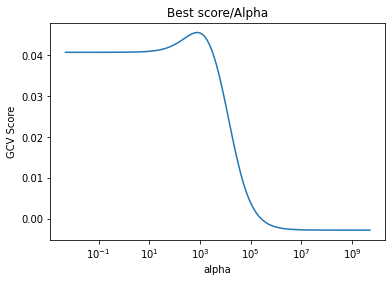

In [30]:
plt.semilogx(alphas,w)
plt.title('Best score/Alpha')
plt.xlabel('alpha')
plt.ylabel('GCV Score')

# XGBoost

In [31]:
# fit model no training data
model = XGBRegressor(booster="gblinear")
model.fit(master_df, y_hat)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=12, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=0, reg_lambda=0,
             scale_pos_weight=1, subsample=None, tree_method=None,
             validate_parameters=1, verbosity=None)

In [32]:
xgb_final = pd.DataFrame(model.coef_,index=master_df.columns).sort_values(0).tail(20).reset_index().rename(columns={'index':'player_id'})
xgb_final.player_id = xgb_final.player_id.astype(int)
xgb_final = pd.merge(xgb_final,players_to_keep,left_on=['player_id'],right_on=['PLAYER_ID'])

xgb_final[['player_id','PLAYER_NAME',0]]

player_id         PLAYER_NAME        0
0      204001  Kristaps Porzingis  2.56828
1      201572         Brook Lopez  2.57935
2     1627826         Ivica Zubac  2.58798
3     1629622           Max Strus  2.69838
4      202710        Jimmy Butler  2.72025
5      201586         Serge Ibaka  2.77508
6      202681        Kyrie Irving  2.84838
7     1628392  Isaiah Hartenstein  2.86635
8     1629680    Matisse Thybulle  2.88946
9     1629130     Duncan Robinson  2.94927
10    1628374     Lauri Markkanen  2.97201
11     201939       Stephen Curry  3.02671
12     201980         Danny Green  3.03224
13     203457        Nerlens Noel  3.09453
14     203999        Nikola Jokic  3.18385
15     201143          Al Horford  3.20320
16     202331         Paul George  3.49358
17    1626166       Cameron Payne  3.49950
18     203500        Steven Adams  4.19960
19    1629723        John Konchar  4.40143

# XGB CV

In [35]:
# define model
model = XGBRegressor()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, master_df, y_hat, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [37]:
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 8.546 (0.073)


# Next Steps

## To Do

 - [x] build 2019-20 master df
 - [x] build all season's master df
 - [x] run for all seasons
 - [x] Associated variance of the beta’s
 - [x] Start ridge regression
 - [x] Ridge regression screen plot
 - [x] XGboost
 - [ ] measures of error, stdev, etc

### Resources
- https://squared2020.com/2017/09/18/deep-dive-on-regularized-adjusted-plus-minus-ii-basic-application-to-2017-nba-data-with-r/

- https://stackoverflow.com/questions/22381497/python-scikit-learn-linear-model-parameter-standard-error

- https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/